# Sample Pipeline

This notebook shows an end to end radio interferometry pipeline from the simulation of the sky to the final image. The pipeline consists of three modules:

- Simulation
    - Sky module: OSKAR
    - Telescope module incl. calibration: OSKAR
- Processing
    - Calibration after observation: RASCIL
    - Deconvolution: RASCIL
- Analysis & comparison
    - Quantitative and qualitative analysis of algorithms

In [1]:
import sys
import oskar
import matplotlib
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
import numpy as np
#from rascil.apps import rascil_imager
#from rascil.processing_components.util.performance import (
#    performance_store_dict,
#    performance_environment,
#)
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

In [ ]:
plt.style.use(astropy_mpl_style)

## Simulation

The sky and telescope simulation is currently provided completely by OSKAR.

### Sky Module

The sky module of OSKAR contains radiation sources, which are defined as array and can be passed to `oskar.Sky.from_array`.

In [22]:
# Set the numerical precision to use.
precision = "single"

# Create a sky model containing three sources from a numpy array.
sky_data = np.array([
        [20.0, -30.0, 1, 0, 0, 0, 100.0e6, -0.7, 0.0, 0,   0,   0],
        [20.0, -30.5, 3, 2, 2, 0, 100.0e6, -0.7, 0.0, 600, 50,  45],
        [20.5, -30.5, 3, 0, 0, 2, 100.0e6, -0.7, 0.0, 700, 10, -10]])
sky = oskar.Sky.from_array(sky_data, precision)  # Pass precision here.

In [38]:
import pandas as pd

records = fits.getdata('../../ext_data/GLEAM_EGC.fits', 1)
sky_array = np.column_stack((records['RAJ2000'], records['DEJ2000'], records['Fpwide']))
sky = oskar.Sky.from_array(sky_array) # 307455 sources
ra0 = 320
dec0 = 45
sky.filter_by_radius(0, 20, ra0, dec0)
sky.num_sources

209

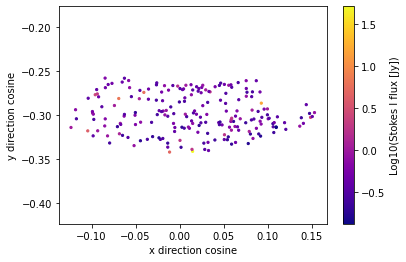

In [39]:
data = sky.to_array()  # Get sky model data as numpy array.
ra = np.radians(data[:, 0] - ra0)
dec = np.radians(data[:, 1])
log_flux = np.log10(data[:, 2])
x = np.cos(dec) * np.sin(ra)
y = np.cos(np.radians(dec0)) * np.sin(dec) - \
            np.sin(np.radians(dec0)) * np.cos(dec) * np.cos(ra)
sc = plt.scatter(x, y, s=5, c=log_flux, cmap='plasma',
            vmin=np.min(log_flux), vmax=np.max(log_flux))
plt.axis('equal')
plt.xlabel('x direction cosine')
plt.ylabel('y direction cosine')
plt.colorbar(sc, label='Log10(Stokes I flux [Jy])')
plt.show()

In [35]:
data = pd.DataFrame.from_records(records)
data

,GLEAM,RAJ2000,DEJ2000,Fpwide,Fintwide,awide,bwide,pawide,Fp076,Fint076,...,a220,b220,pa220,Fp227,Fint227,a227,b227,pa227,alpha,Fintfit200
0,J235139-894114,357.914368,-89.687309,0.262282,0.248581,219.263,146.4811,-4.158033,0.531743,0.528997,...,171.534,127.1215,-4.158033,0.097147,0.090779,170.630,123.0671,-4.158033,-0.370882,0.271901
1,J223320-891247,338.336243,-89.213310,0.160685,0.150291,217.707,145.0885,8.403455,-0.032964,-0.032702,...,169.540,125.5117,8.403455,0.084467,0.076873,168.625,121.4038,8.403455,NaN,NaN
2,J231335-890921,348.399048,-89.155968,0.311750,0.320281,234.137,148.1622,-1.929386,0.459728,0.463359,...,190.178,129.0525,-1.929386,0.219189,0.230755,189.363,125.0609,-1.929386,-0.751062,0.321428
3,J230111-884502,345.296844,-88.750610,1.540468,1.589200,203.822,170.7923,-2.558145,2.683800,2.686571,...,154.506,151.2983,87.441856,1.146250,1.157487,151.188,150.2724,87.441856,-0.453153,1.496247
4,J211508-884427,318.784729,-88.740990,0.137430,0.192555,282.809,167.1542,26.895504,0.368415,0.393777,...,247.645,150.4759,26.895504,0.015579,0.025159,247.020,147.0669,26.895504,-0.239030,0.199019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307450,J211616+190343,319.068054,19.062172,0.123978,0.124824,168.081,135.8049,6.587005,0.796307,0.797789,...,146.567,111.1048,6.587005,0.053839,0.054595,141.525,109.5933,6.587005,-1.415547,0.168954
307451,J030237+015253,45.658031,1.881389,0.054530,0.057039,172.555,117.2263,86.598587,0.708015,0.719054,...,152.974,91.5132,86.598587,0.112432,0.120027,150.255,88.8392,86.598587,-1.544697,0.144874
307452,J075847+182949,119.696312,18.497141,0.063082,0.080149,219.053,135.7612,3.673847,0.300709,0.314990,...,201.648,109.5747,3.673847,0.076380,0.104249,198.539,106.4075,3.673847,NaN,NaN
307453,J102809+162753,157.039459,16.464996,0.083077,0.144503,305.075,130.9386,-3.672582,1.014757,1.189469,...,284.026,102.2411,-3.672582,0.079995,0.172456,282.071,98.8247,-3.672582,NaN,NaN


In [6]:
# filter all sky parameters (not values) you intend to use in your sky-simulation
import re

oskar_sky_parameters = {'parameter':['right ascension','declination','Stokes I flux','Stokes Q flux',
                                     'Stokes U flux','Stokes V flux','reference frequency','spectral index',
                                     'rotation measure','major axis FWHM','minor axis FWHM','position angle'],
                        'unit':['deg','deg','Jy','Jy','Jy','Jy','Hz','N/A','rad / m^2','arcsec','arcsec','deg'],
                        'regex':['RAJ2000','DEJ2000','^Fp',None,None,None,None,'alpha',None,'a','b','pa'],
                        'extr_freq':[False, False, True, False, False, False, False, False, True, True, True]}
cols = []
extr_freq_regex = '[0-9]{3}'
i = 0
for extr_freq, exp in zip(oskar_sky_parameters['extr_freq'], oskar_sky_parameters['regex']):
    if exp != None:
        exp = '^'+exp+extr_freq_regex+'$' if extr_freq else '^'+exp+'$'
        col_names = [col for i, col in enumerate(data.columns) if re.match(exp, col)]
        col_names_with_freq = [(col, -1 if not extr_freq else int(re.findall(extr_freq_regex, col)[0]))
                               for col in col_names]
        cols = cols + col_names_with_freq
identifier = data.columns[0]
params = [(identifier, -1)] + cols # assumes that identifier is on index 0
params = pd.DataFrame(params, columns=['param','freq'])
data = data.loc[:,params['param']]
row = data.iloc[0:1]
row

,GLEAM,RAJ2000,DEJ2000,Fp076,Fp084,Fp092,Fp099,Fp107,Fp115,Fp122,...,b158,b166,b174,b181,b189,b197,b204,b212,b220,b227
0,J235139-894114,357.914368,-89.687309,0.531743,0.512256,0.427771,0.444216,0.332228,0.296139,0.202653,...,170.158997,165.932007,148.798996,141.9525,138.8363,130.4126,134.0238,125.0827,127.1215,123.0671


In [7]:
non_freq_params = params[params['freq'] == -1]['param']
freq_params = params[params['freq'] != -1]
for freq, group in freq_params.groupby(by='freq'):
    pass
non_freq_params

0       GLEAM
1     RAJ2000
2     DEJ2000
23      alpha
Name: param, dtype: object

In [ ]:
sky.he

In [24]:
from astropy.wcs.utils import celestial_frame_to_wcs, skycoord_to_pixel
from astropy.coordinates import FK5, SkyCoord
#?celestial_frame_to_wcs

frame = FK5(equinox='J2000')
wcs = celestial_frame_to_wcs(frame)
wcs.to_header()

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                  0.0 / Pixel coordinate of reference point            
CRPIX2  =                  0.0 / Pixel coordinate of reference point            
CDELT1  =                  1.0 / [deg] Coordinate increment at reference point  
CDELT2  =                  1.0 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---TAN'           / Right ascension, gnomonic projection           
CTYPE2  = 'DEC--TAN'           / Declination, gnomonic projection               
CRVAL1  =                  0.0 / [deg] Coordinate value at reference point      
CRVAL2  =                  0.0 / [deg] Coordinate value at reference point      
LONPOLE =                180.0 / [deg] Native longitude of celestial pole       
LATPOLE =                  0

In [54]:
#c = SkyCoord(records['RAJ2000'], records['DEJ2000'], frame="fk5", unit="deg", equinox='J2000')
c = SkyCoord([0],[0], frame="fk5", unit="deg", equinox='J2000')
xp, yp = skycoord_to_pixel(c, wcs)
plt.scatter(xp, yp)

ValueError: WCS should contain celestial component

In [51]:
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u

gleam = fits.open('../../ext_data/GLEAM_EGC.fits')
header = gleam[1].header
wcs = WCS(header)
#SkyCoord(10*u.deg, 86*u.deg, frame='icrs')
header

XTENSION= 'BINTABLE'           / Binary Table Extension                         
BITPIX  =                    8 / binary data                                    
NAXIS   =                    2 / Simple 2-D matrix                              
NAXIS1  =                  834 / Number of bytes per record                     
NAXIS2  =               307455 / Number of records                              
PCOUNT  =                    0 / Get rid of random parameters                   
GCOUNT  =                    1 / Only one group (isn't it obvious?)             
TFIELDS =                  110 / Number of data fields (columns)                
CDS-CAT = 'VIII/100'           / Catalogue designation in CDS nomenclature      
         GaLactic and Extragalactic All-sky MWA survey (Hurley-Walker+, 2016)   
EXTNAME = 'VIII_100_gleamegc'  / Identification of the table                    
CDS-NAME= 'VIII/100/gleamegc'  / Table name in METAtab                          
         GLEAM EGC catalog, 

### Telescope Module

Various observation parameters and meta information `params` must be passed to the telescope module `oskar.Interferometer` of OSKAR as `oskar.SettingsTree`.

In [ ]:
# Basic settings. (Note that the sky model is set up later.)
params = {
    "simulator": {
        "use_gpus": False
    },
    "observation" : {
        "num_channels": 64,
        "start_frequency_hz": 100e6,
        "frequency_inc_hz": 20e6,
        "phase_centre_ra_deg": 20,
        "phase_centre_dec_deg": -30,
        "num_time_steps": 24,
        "start_time_utc": "01-01-2000 12:00:00.000",
        "length": "12:00:00.000"
    },
    "telescope": {
        "input_directory": "../data/telescope.tm"
    },
    "interferometer": {
        "ms_filename": "visibilities.ms",
        "channel_bandwidth_hz": 1e6,
        "time_average_sec": 10
    }
}
settings = oskar.SettingsTree("oskar_sim_interferometer")
settings.from_dict(params)

if precision == "single":
    settings["simulator/double_precision"] = False

# Set the sky model and run the simulation.
sim = oskar.Interferometer(settings=settings)

### Observation Simulation

Now the sky module must be passed to the interferometer and the simulation of the observation must be started to generate the measurement set.

In [ ]:
sim.set_sky_model(sky)
sim.run()

## Processing

After the observation is made with the telescope, a calibration of the measured data must be performed, followed by the reconstruction of the image.

### Calibration after Observation

toDo

In [ ]:
# Code here

### Imaging

Start an mmclean algorithm with the visibilites.ms as an input to deconvolve. 
To use dask cluster where you can see the progress, first create a dask cluster in the dask-extension on the left. 
Then copy the scheduler adress into the variable below. It might be correct already.

If you don't do this, remove the --dask_scheduler option from the options in the start_imager call.
Then RASCIL starts its own scheduler, you will however not be able to see the dashbaord, as the port is probably not forwarded by docker.

In [ ]:
#def start_imager(rawargs):
#    parser = rascil_imager.cli_parser()
#    args = parser.parse_args(rawargs)
#    performance_environment(args.performance_file, mode="w")
#    performance_store_dict(args.performance_file, "cli_args", vars(args), mode="a")
#    image_name = rascil_imager.imager(args)
#
#start_imager(
#    [
#        '--ingest_msname','visibilities.ms',
#        '--ingest_dd', '0', 
#        '--ingest_vis_nchan', '64',
#        '--ingest_chan_per_blockvis', '4' ,
#        '--ingest_average_blockvis', 'True',
#        '--imaging_npixel', '2048', 
#        '--imaging_cellsize', '3.878509448876288e-05',
#        '--imaging_weighting', 'robust',
#        '--imaging_robustness', '-0.5',
#        '--clean_nmajor', '5' ,
#        '--clean_algorithm', 'mmclean',
#        '--clean_scales', '0', '6', '10', '30', '60',
#        '--clean_fractional_threshold', '0.3',
#        '--clean_threshold', '0.12e-3',
#        '--clean_nmoment' ,'5',
#        '--clean_psf_support', '640',
#        '--clean_restored_output', 'integrated'
#    ])

In [ ]:
from rascil.workflows import \
    invert_list_rsexecute_workflow, \
    deconvolve_list_rsexecute_workflow, \
    create_blockvisibility_from_ms_rsexecute, rsexecute, \
    weight_list_rsexecute_workflow, \
    continuum_imaging_skymodel_list_rsexecute_workflow

from rascil.workflows.rsexecute.execution_support import rsexecute
from rascil.processing_components.visibility.operations import convert_blockvisibility_to_stokesI
from rascil.data_models import PolarisationFrame
import dask

In [ ]:
# read visibilities from ms locally (to prevent dask workers from not finding the ms file)
rsexecute.set_client(use_dask=False)

In [ ]:
dds = [0]
channels_per_dd = 64
nchan_per_blockvis = 4
nout = channels_per_dd // nchan_per_blockvis

# Create a list of blockvisibilities
bvis_list = create_blockvisibility_from_ms_rsexecute('visibilities.ms/', 
                                                     nchan_per_blockvis=nchan_per_blockvis, 
                                                     dds=dds, 
                                                     nout=nout,
                                                     average_channels=True)

### Info: Dask Cluster

Create a new local cluster on the left with the dask-labextension.
Then just drag the blue box of the cluster in the notebook and it will create a cell like the one below.
Or just change the scheduler address in the box below.

In [ ]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:43619")
client

In [ ]:
#set execute to existing dask cluster (Tip: if no cluster exists you can create one in the dask-labextension tab to the left)
rsexecute.set_client(client=client, use_dask=True)

In [ ]:
# covnert visibility to stokes I
bvis_list = [rsexecute.execute(convert_blockvisibility_to_stokesI)(vis) for vis in bvis_list]

In [ ]:
#create model images from all visibilites
modelimage_list = [rsexecute.execute(create_image_from_visibility)(vis, 
                                                                   npixel=2048, 
                                                                   nchan=1, 
                                                                   cellsize=3.878509448876288e-05, 
                                                                   polarisationFrame=PolarisationFrame('stokesI')) 
                   for vis in bvis_list]

In [ ]:
# weight visibilities
bvis_list = weight_list_rsexecute_workflow(bvis_list, 
                                        modelimage_list, 
                                        weigthing= 'robust', 
                                        robustness=-0.5)

In [ ]:
# compute deconvolution
result = continuum_imaging_skymodel_list_rsexecute_workflow(
    bvis_list,
    modelimage_list,
    context='ng',
    threads=4,
    wstacking=True,
    niter=1000,
    nmajor=5,
    algorithm='mmclean',
    gain=0.1,
    scales= [0, 6, 10, 30, 60],
    fractional_threshold=0.3,
    threshold=0.00012,
    nmoment=5,
    psf_support=640,
    restored_output='integrated',
    deconvolve_facets=1,
    deconvolve_overlap=32,
    deconvolve_taper='tukey',
    restore_facets=1,
    restore_overlap=32,
    restore_taper='tukey',
    dft_compute_kernel=None,
    component_threshold=None,
    component_method='fit',
    flat_sky=False,
    clean_beam=None,
)

# start computation on dask cluster
result = rsexecute.compute(result, sync=True)

### Info: Dask Dashboard

To see the execution of the dask-dashboard, you can now simply open the different panels in the dask-labextension to the left. For example the Graph or the Task Stream give you a good representation where the computation currently is.

Also if you stop the calculation with the stop button on top. You need to run the client setup cell again, else you will encounter an IOLoop closed error.

## Analysis and Comparison

toDo

In [ ]:
# matplotlib.use("Agg") from rascil_imager.py causes the problem that matplotlib isn't able to plot in the notebook
image_file = get_pkg_data_filename('visibilities_nmoment5_cip_deconvolved.fits')
fits.info(image_file)

In [ ]:
image_data = fits.getdata(image_file)
image_data = np.log(image_data.sum(axis=(0,1)))
_ = plt.figure(figsize=(8,6))
_ = plt.imshow(image_data, cmap='gray')
_ = plt.colorbar()